IMPORTING IMPORTANT LIBRARIES


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
sns.set_style("whitegrid")

GETTING THE BENCHMARK VALUES

In [ ]:
st = '2023-01-01'
ed = '2023-12-31'
benchmarkdf = yf.download(tickers = "^NSEMDCP50", start = st, end  = ed, progress = False, period = '1d')
benchmarkdf.drop(columns = ["Open","Low","High","Volume","Adj Close"], inplace = True)
benchmarkdf

,Close
Date,
2023-01-02,8821.799805
2023-01-03,8843.349609
2023-01-04,8745.700195
2023-01-05,8808.599609
2023-01-06,8752.299805
...,...
2023-12-22,12838.200195
2023-12-26,12905.599609
2023-12-27,12946.500000


CONSERIDERING INITIAL INVESTMENT OF 10000

In [ ]:
initial_investment = 100000
shares_bought = initial_investment / benchmarkdf['Close'][0]

benchmarkdf['Portfolio Value'] = benchmarkdf['Close']*shares_bought
benchmarkdf

,Close,Portfolio Value
Date,,
2023-01-02,8821.799805,100000.000000
2023-01-03,8843.349609,100244.279004
2023-01-04,8745.700195,99137.368666
2023-01-05,8808.599609,99850.368455
2023-01-06,8752.299805,99212.178903
...,...,...
2023-12-22,12838.200195,145528.128948
2023-12-26,12905.599609,146292.138737
2023-12-27,12946.500000,146755.767379


GETTING THE BENCHMARK SHARPE RATIO AND BENCHMARK RETURN

In [ ]:
final_portfolio_value = benchmarkdf['Portfolio Value'][-1]
benchmark_returns = (final_portfolio_value - initial_investment)*100 / initial_investment
print("Benchmark Returns:", round(benchmark_returns,2),"%")

s = benchmarkdf['Portfolio Value']
s = np.log(s / s.shift(1))
s = s[1:]
sigma = (np.std(s)*math.sqrt(252))
s = s.mean()*252
print(sigma)
ra = s
print(ra)
rb = 0.07
benchmark_sr = ((ra-rb)/sigma) # Sharpe ratio
print("Benchmark Sharpe Ratio:", round(benchmark_sr,2))

Benchmark Returns: 49.01 %
0.12340268141198116
0.4118875560455705
Benchmark Sharpe Ratio: 2.77


PLOTTING THE BENCHMARK PORTFOLIO

<Axes: xlabel='Date'>

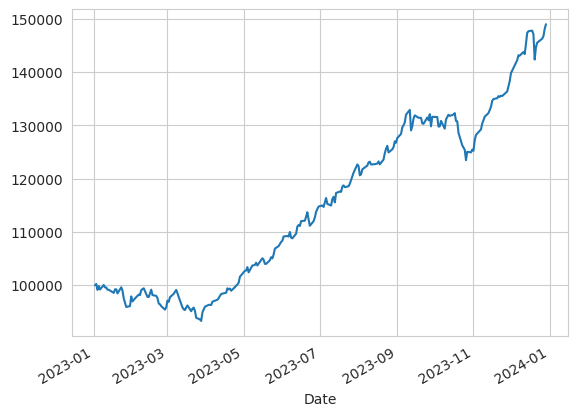

In [ ]:
benchmarkdf['Portfolio Value'].plot(kind='line')




---



**ACTUAL WORK STARTS HERE**

In [ ]:
NUM_SIMULATIONS = 50000
NUM_TRADING_DAYS = 252
INITIAL_INV = 10000

stocks =["LUPIN.NS", "VOLTAS.NS", "NMDC.NS", "ZYDUSLIFE.NS", "SAIL.NS"] #TESTING FOR THESE STOCKS

from itertools import combinations
numbers = range(len(stocks))

combs = list(combinations(numbers, 3))

for comb in combs:
  stocks_new = [stocks[i] for i in comb]
  # print(stocks_new)
  stock_data = {}
  for stock in stocks_new:
      ticker = yf.Ticker(stock)
      print(ticker)
      stock_data[stock] = ticker.history(start = st, end = ed)['Close']

  stock_prices = pd.DataFrame(stock_data)
  stock_prices.dropna(inplace=True)
  # print(stock_prices)

  daily_rets = {}

  for stock in stocks_new:
    daily_rets[stock] = stock_data[stock].pct_change()

  stock_rets = pd.DataFrame(daily_rets)

  # stock_rets

  log_rets ={}

  for stock in stocks_new:
    log_rets[stock] = np.log(1+daily_rets[stock])

  log_returns = pd.DataFrame(log_rets)
  log_returns.dropna(inplace=True)

  portfolio_weights = []
  portfolio_returns = []
  portfolio_risks = []

  for i in range(NUM_SIMULATIONS):
    w = np.random.random(len(stocks_new))
    w /= np.sum(w)         #create an array of weights for a portfolio (use np.random.random)
                                  #weights for each stock should be fractional
    portfolio_weights.append(w)
    port_return = np.sum(log_returns.mean()*w)*NUM_TRADING_DAYS
    portfolio_returns.append(port_return)
    port_risk = np.sqrt(np.dot(w.T,np.dot(log_returns.cov()*NUM_TRADING_DAYS,w)))
    portfolio_risks.append(port_risk)

  porfolio_weights = np.array(portfolio_weights)
  portfolio_returns = np.array(portfolio_returns)
  portfolio_risks = np.array(portfolio_risks)

  riskFree = 0.07
  sharpe_ratios  = np.array((portfolio_returns-riskFree)/portfolio_risks)                      # use the above variables and the formula for sharpe ratio
  portfolios = pd.DataFrame({"Return": portfolio_returns,"Risk": portfolio_risks,"Sharpe": sharpe_ratios })


  portfolios = pd.DataFrame({"Return": portfolio_returns,"Risk": portfolio_risks,"Sharpe": sharpe_ratios })
  ind = 0

  for i in range(0,len(sharpe_ratios)):
    if(sharpe_ratios[i] == np.amax(sharpe_ratios)):
      ind = i

  weights = portfolio_weights[ind]
  # print(ind)
  shares = []
  df = stock_prices.copy()
  weights=weights*initial_investment
  closing_prices = []
  for stock in stocks_new:
    closing_prices.append(stock_prices[stock][0])
  shares = weights/closing_prices
  # print(shares)
  portfolio_values = []
  for i in range(0,len(stock_prices)):
    closing_prices = []
    for stock in stocks_new:
      closing_prices.append(stock_prices[stock][i])
    portfolio_values.append(np.sum(closing_prices*shares))

  df.insert(3,'Portfolio Value',portfolio_values)
  # print(df)
  final_portfolio_value = df['Portfolio Value'][-1]
  df_returns = (final_portfolio_value - initial_investment)*100 / initial_investment

  print("Combo Returns:", round(df_returns,2),"%")

  # print(sharpe_ratios)
  df_sr = sharpe_ratios[ind]
  print("Combo Sharpe Ratio:", round(df_sr,2))
  print()

  # print()

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <NMDC.NS>
Combo Returns: 73.85 %
Combo Sharpe Ratio: 2.6

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
Combo Returns: 69.41 %
Combo Sharpe Ratio: 2.53

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <SAIL.NS>
Combo Returns: 68.04 %
Combo Sharpe Ratio: 2.3

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
Combo Returns: 74.04 %
Combo Sharpe Ratio: 2.83

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <SAIL.NS>
Combo Returns: 79.23 %
Combo Sharpe Ratio: 2.58

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
yfinance.Ticker object <SAIL.NS>
Combo Returns: 70.75 %
Combo Sharpe Ratio: 2.54

yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker obj